In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

/home/qazw5741/miniconda3/envs/SAM/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [4]:
import json
with open('/database/changhee/OCHuman/ochuman.json','r') as f:
    pred_data=json.load(f)

In [5]:
pred_data['keypoint_visible']

{'vis': 1, 'others_occluded': 3, 'self_occluded': 2, 'missing': 0}

In [6]:
print(pred_data['images'][0].keys())

dict_keys(['annotations', 'file_name', 'image_id', 'width', 'height'])


In [38]:
test_coord=np.array(pred_data['images'][5]['annotations'][0]['keypoints']).reshape(-1,3)
img_name=pred_data['images'][5]['file_name']

In [39]:
new_j=[]
for i in test_coord:
    if i[2]!=0 and i[2]==1:
        new_j.append(i)
new_j=np.array(new_j)
print(new_j)

[[673.         117.           1.        ]
 [837.         109.           1.        ]
 [888.         203.           1.        ]
 [892.         292.           1.        ]
 [753.         671.           1.        ]
 [842.         378.           1.        ]
 [875.         526.           1.        ]
 [892.         695.           1.        ]
 [751.          88.           1.        ]
 [778.97877582  23.02639108   1.        ]
 [732.19043216  37.27664803   1.        ]
 [720.31521803  19.70133112   1.        ]
 [747.62821052  17.08878402   1.        ]]


In [40]:
new_j[:,2]=1
input_point = new_j[:2,:2]
input_label = new_j[:2,2]

In [41]:
oc_path="/database/changhee/OCHuman/images"
import os.path as osp
image=cv2.imread(osp.join(oc_path,img_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

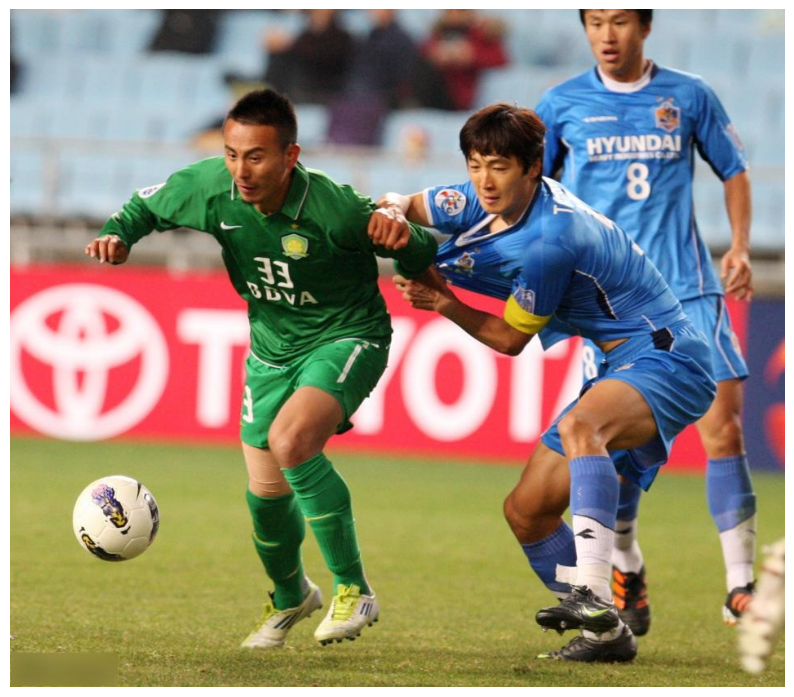

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.savefig("./assets/OC_input1.jpg",bbox_inches='tight', pad_inches=0)
plt.show()

In [43]:
input_point = new_j[:,:2]
input_label = new_j[:,2]

In [44]:
input_point

array([[673.        , 117.        ],
       [837.        , 109.        ],
       [888.        , 203.        ],
       [892.        , 292.        ],
       [753.        , 671.        ],
       [842.        , 378.        ],
       [875.        , 526.        ],
       [892.        , 695.        ],
       [751.        ,  88.        ],
       [778.97877582,  23.02639108],
       [732.19043216,  37.27664803],
       [720.31521803,  19.70133112],
       [747.62821052,  17.08878402]])

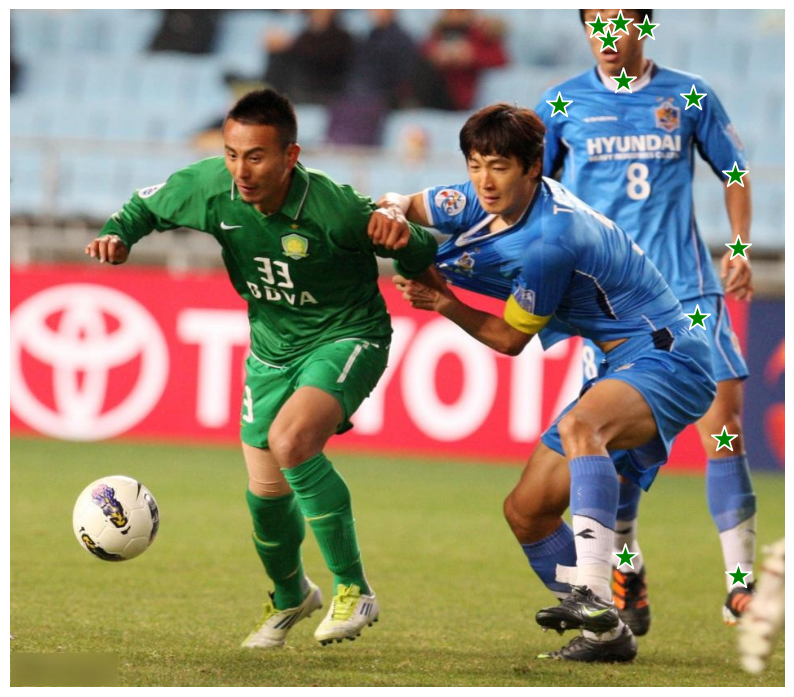

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.savefig("./assets/OC_2d_input1.jpg",bbox_inches='tight', pad_inches=0)
plt.show()  

In [46]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/qazw5741/segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [47]:
predictor.set_image(image)

In [48]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [49]:
scores

array([0.81919307, 0.96159494, 0.97549474], dtype=float32)

In [50]:
logits.shape

(3, 256, 256)

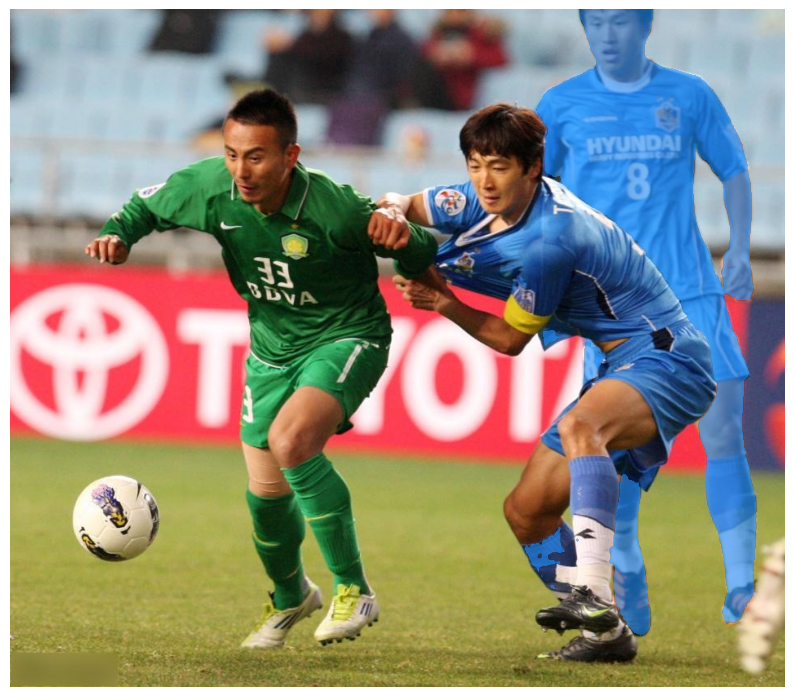

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[2], plt.gca())
plt.axis('off')
plt.savefig("./assets/OC_mask1.jpg",bbox_inches='tight', pad_inches=0)
plt.show() 